![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### Load Data (3 Marks)

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from  google.colab import drive
import os
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import keras

from nltk.tokenize import word_tokenize,sent_tokenize
from keras.models import Sequential
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/My Drive/AIML/GreatLearning/NLP/')

Load the sarcasm dataset

In [6]:
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

data = list(parseJson('./Sarcasm_Headlines_Dataset.json'))

In [7]:
data

[{'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html',
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031',
  'headline': 'inclement weather prevents liar from getting to work',
  'is_sarcastic': 1},
 {'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546',
  'headline': "mother comes pretty close to using wor

In [8]:
data_df = pd.DataFrame.from_records(data)

In [9]:
data_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### Drop `article_link` from dataset (3 Marks)

In [10]:
data_df.drop('article_link', axis='columns', inplace=True)

In [11]:
data_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


### Get length of each headline and add a column for that (3 Marks)

In [12]:
data_df["headLine_length"]= data_df["headline"].str.len()

In [13]:
data_df.head()

,is_sarcastic,headline,headLine_length
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep. totally nails why congress is falling...,79
2,0,eat your veggies: 9 deliciously different recipes,49
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word 'strea...,61


Checking for null values

In [14]:
data_df.isna().sum() 

is_sarcastic       0
headline           0
headLine_length    0
dtype: int64

Visualization of word count on each category

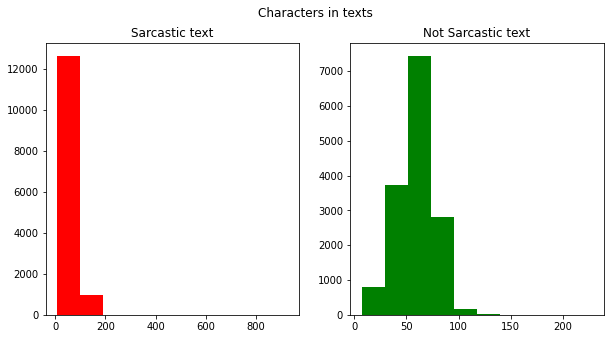

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data_df[data_df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=data_df[data_df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

Visualization of category-wise count

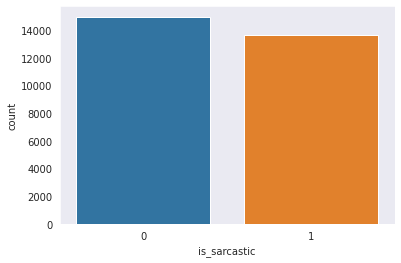

In [16]:
sns.set_style("dark")
sns.countplot(data_df.is_sarcastic)

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [17]:
max_features = 10000
maxlen = 25
embedding_size = 200

In [18]:
words = []
for i in data_df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'of',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'why',
  'congress',
  'is',
  'falling',
  'short',
  'on',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'your', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'from', 'getting', 'to', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'to',
  'using',
  'word',
  "'streaming'",
  'correctly']]

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [19]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)

### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [20]:
x = sequence.pad_sequences(tokenized_train, maxlen = 25)

### Vocab mapping
- There is no word for 0th index

In [21]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'man': 12,
 'from': 13,
 'at': 14,
 'trump': 15,
 'about': 16,
 'by': 17,
 'after': 18,
 'you': 19,
 'this': 20,
 'be': 21,
 'as': 22,
 'out': 23,
 'that': 24,
 'how': 25,
 'up': 26,
 'it': 27,
 'not': 28,
 'he': 29,
 'his': 30,
 'are': 31,
 'just': 32,
 'your': 33,
 'what': 34,
 'who': 35,
 'has': 36,
 'will': 37,
 'all': 38,
 'into': 39,
 'more': 40,
 'have': 41,
 'one': 42,
 'over': 43,
 'why': 44,
 'area': 45,
 'can': 46,
 'woman': 47,
 'says': 48,
 'donald': 49,
 'report:': 50,
 'u.s.': 51,
 'day': 52,
 'like': 53,
 'get': 54,
 'first': 55,
 'her': 56,
 'time': 57,
 "trump's": 58,
 'no': 59,
 'an': 60,
 'now': 61,
 'people': 62,
 'off': 63,
 'still': 64,
 'house': 65,
 'white': 66,
 'than': 67,
 'was': 68,
 'make': 69,
 'life': 70,
 'if': 71,
 'obama': 72,
 'back': 73,
 'women': 74,
 'my': 75,
 'when': 76,
 'down': 77,
 'could': 78,
 'their': 79,
 'they': 80,
 'bef

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [22]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

38235


### Load Glove Word Embeddings (3 Marks)

In [23]:
EMBEDDING_FILE = './glove.6B.200d.txt'

### Create embedding matrix

In [24]:
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [25]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(num_words, output_dim=embedding_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

### Compile the model (3 Marks)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          7647000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,984,153
Trainable params: 7,984,153
Non-trainable params: 0
_________________________________________________________________


Split dataset into train-test

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, data_df.is_sarcastic , test_size = 0.3 , random_state = 0) 

### Fit the model (4 Marks)

In [28]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
157/157 [==============================] - 43s 272ms/step - loss: 0.4246 - acc: 0.7948 - val_loss: 0.3038 - val_acc: 0.8739
Epoch 2/3
157/157 [==============================] - 42s 270ms/step - loss: 0.2151 - acc: 0.9128 - val_loss: 0.3275 - val_acc: 0.8740
Epoch 3/3
157/157 [==============================] - 40s 257ms/step - loss: 0.1292 - acc: 0.9494 - val_loss: 0.4420 - val_acc: 0.8685


ANALYSIS AFTER TRAINING OF THE MODEL

*   Check the prediction





In [29]:
pred = model.predict_classes(x_test)
pred[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

*   Classification Report



In [30]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.89      0.86      0.87      4560
    Sarcastic       0.85      0.88      0.86      4026

     accuracy                           0.87      8586
    macro avg       0.87      0.87      0.87      8586
 weighted avg       0.87      0.87      0.87      8586



In [31]:
cm = confusion_matrix(y_test,pred)
cm

array([[3932,  628],
       [ 501, 3525]])

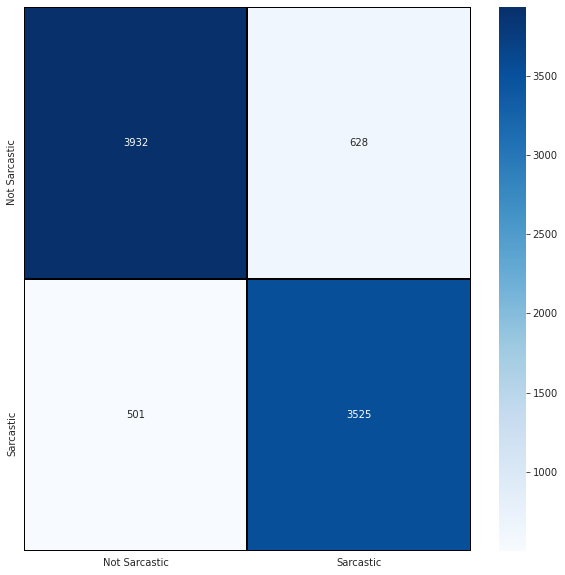

In [32]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])